In [ ]:
#hide
#default_exp models
from nbdev.showdoc import *

# The Classic Context Maintenance and Retrieval (CMR) Model

To help explore equivalence and distinctions between our instance-based and the classical specification of CMR, it
would help to have an implementation of CMR handy! We reproduce one here. Language explaining the model is mostly lifted from the source below; make sure to cite it if used:
> Morton, N. W., & Polyn, S. M. (2016). A predictive framework for evaluating models of semantic organization in free
> recall. Journal of Memory and Language, 86, 119-140. 

In [ ]:
# exports
# hide
import numpy as np
import math
from numba import float64, int32, boolean
from numba.experimental import jitclass

cmr_spec = [
    ('item_count', int32), 
    ('encoding_drift_rate', float64),
    ('start_drift_rate', float64),
    ('recall_drift_rate', float64),
    ('shared_support', float64),
    ('item_support', float64),
    ('learning_rate', float64),
    ('primacy_scale', float64),
    ('primacy_decay', float64),
    ('stop_probability_scale', float64),
    ('stop_probability_growth', float64),
    ('choice_sensitivity', float64),
    ('context', float64[::1]),
    ('preretrieval_context', float64[::1]),
    ('recall', float64[::1]),
    ('retrieving', boolean),
    ('recall_total', int32),
    ('primacy_weighting', float64[::1]),
    ('probabilities', float64[::1]),
    ('mfc', float64[:,::1]),
    ('mcf', float64[:,::1]),
    ('encoding_index', int32),
    ('items', float64[:,::1])
]

@jitclass(cmr_spec)
class CMR:
    """
    The Context Maintenance and Retrieval (CMR) as specified by Morton and Polyn (2016).

    CMR takes the form of a simplified neural network with two interacting representations, a feature-based
    representation of the studied item and a contextual representation (the context layer, $C$). The two layers
    communicate with one another through two sets of associative connections represented by matrices $M^{FC}$ and
    $M^{CF}$. Each of these weight matrices contains both pre-experimental associations and new associations learned
    during the experiment.

    Attributes:  
    - mfc: $M^{FC}$, matrix tracking item-to-context associations
    - mcf: $M^{CF}$, matrix tracking context-to-item associations 
    - context: $C$, vector reflecting a recency-weighted average of encoded items  
    - item_count: $N$, integer count of unique items relevant to simulation  
    - encoding_drift_rate: ${\beta}_{enc}$, rate of context drift during item encoding  
    - start_drift_rate: ${\beta}_{start}$, amount of start-list context retrieved at start of recall
    - recall_drift_rate: ${\beta}_{rec}$, rate of context drift during recall
    - shared_support: ${\alpha}$, amount of support items initially have for one another 
    - item_support: ${\delta}$, initial strength of the diagonal of pre-experimental contextual associations 
    - learning_rate: ${\gamma}$, amount of experimental context retrieved by a recalled item 
    - primacy_scale: ${\phi}_{s}$, scaling of primacy gradient on trace activations 
    - primacy_decay: ${\phi}_{d}$, rate of decay of primacy gradient
    - choice_sensitivity: ${\tau}$, exponential weighting of similarity-driven activation
    - stop_probability_scale: ${\theta}_{s}$, scaling of the stop probability over output position
    - stop_probability_growth: ${\theta}_{r}$, rate of increase in stop probability over output position
    """
    def __init__(self, item_count, presentation_count, encoding_drift_rate, start_drift_rate, recall_drift_rate, shared_support,
                 item_support, learning_rate, primacy_scale, primacy_decay, stop_probability_scale,
                 stop_probability_growth, choice_sensitivity):

        # store initial parameters
        self.item_count = item_count
        self.encoding_drift_rate = encoding_drift_rate
        self.start_drift_rate = start_drift_rate
        self.recall_drift_rate = recall_drift_rate
        self.shared_support = shared_support
        self.item_support = item_support
        self.learning_rate = learning_rate
        self.primacy_scale = primacy_scale
        self.primacy_decay = primacy_decay
        self.stop_probability_scale = stop_probability_scale
        self.stop_probability_growth = stop_probability_growth
        self.choice_sensitivity = choice_sensitivity
        
        # at the start of the list context is initialized with a state orthogonal to the pre-experimental context
        # associated with the set of items
        self.context = np.zeros(item_count + 1)
        self.context[0] = 1
        self.preretrieval_context = self.context
        self.recall = np.zeros(item_count) # recalls has at most `item_count` entries
        self.retrieving = False
        self.recall_total = 0

        # predefine primacy weighting vectors
        self.primacy_weighting = primacy_scale * np.exp(-primacy_decay * np.arange(presentation_count)) + 1

        # preallocate for outcome_probabilities
        self.probabilities = np.zeros((item_count + 1))

        # The two layers communicate with one another through two sets of associative connections represented by
        # matrices Mfc and Mcf. Pre-experimental Mfc is 1-learning_rate and pre-experimental Mcf is item_support for 
        # i=j. For i!=j, Mcf is shared_support.
        self.mfc = np.eye(item_count, item_count+1, 1) * (1 - learning_rate)
        self.mcf = np.ones((item_count, item_count)) * shared_support
        for i in range(item_count):
            self.mcf[i, i] = item_support
        self.mcf =  np.vstack((np.zeros((1, item_count)), self.mcf))
        self.encoding_index = 0
        self.items = np.eye(item_count, item_count)

    def experience(self, experiences):
        """
        Updates model context, mfc, and mcf based on content of each experience and model state.
        """
        
        for i in range(len(experiences)):
            self.update_context(self.encoding_drift_rate, experiences[i])
            self.mfc += self.learning_rate * np.outer(self.context, experiences[i]).T
            self.mcf += self.primacy_weighting[self.encoding_index] * np.outer(self.context, experiences[i])
            self.encoding_index += 1

    def update_context(self, drift_rate, experience=None):
        """
        Updates context based on drift rate and either initial context or specified experience
        """

        # first pre-experimental or initial context is retrieved
        if experience is not None:
            context_input = np.dot(experience, self.mfc)
            context_input = context_input / np.sqrt(np.sum(np.square(context_input))) # norm to length 1
        else:
            context_input = np.zeros((self.item_count+1))
            context_input[0] = 1

        # updated context is sum of context and input, modulated by rho to have len 1 and some drift_rate
        rho = np.sqrt(1 + np.square(drift_rate) * (np.square(self.context * context_input) - 1)) - (
            drift_rate * (self.context * context_input))
        self.context = (rho * self.context) + (drift_rate * context_input)

    def activations(self, probe, use_mfc=False):
        """
        Retrieves set of activations corresponding to presenting the probe to mcf. If probe unspecified, uses the 
        current state of context.
        """
        if use_mfc:
            return np.dot(probe, self.mfc) + 10e-7
        else:
            return np.dot(probe, self.mcf) + 10e-7
        
    def outcome_probabilities(self, activation_cue):
        """
        Computes current item recall probabilities given model state and any specified activation pattern/cue.
        """

        activation = self.activations(activation_cue)
        activation = np.power(activation, self.choice_sensitivity)

        self.probabilities = np.zeros((self.item_count + 1))
        self.probabilities[0] = min(self.stop_probability_scale * np.exp(
            self.recall_total * self.stop_probability_growth), 1.0)

        if self.probabilities[0] < 1:
            for already_recalled_item in self.recall[:self.recall_total]:
                activation[int(already_recalled_item)] = 0
        self.probabilities[1:] = (1-self.probabilities[0]) * activation / np.sum(activation)

        return self.probabilities

    def free_recall(self, steps=None):
        """
        Simulates free recall for the specified number of steps based on model state.
        """

        # some amount of the pre-list context is reinstated before initiating recall
        if not self.retrieving:
            self.recall = np.zeros(self.item_count)
            self.recall_total = 0
            self.preretrieval_context = self.context
            self.update_context(self.start_drift_rate)
            self.retrieving = True

        # number of items to retrieve is # of items left to recall if steps is unspecified
        if steps is None:
            steps = self.item_count - self.recall_total
        steps = self.recall_total + steps
        
        # at each recall attempt
        while self.recall_total < steps:

            # the current state of context is used as a retrieval cue to attempt recall of a studied item
            # compute outcome probabilities and make choice based on distribution
            outcome_probabilities = self.outcome_probabilities(self.context)
            if np.any(outcome_probabilities[1:]):
                choice = np.sum(np.cumsum(outcome_probabilities) < np.random.rand())
            else:
                choice = 0

            # resolve and maybe store outcome
            # we stop recall if no choice is made (0)
            if choice == 0:
                self.retrieving = False
                self.context = self.preretrieval_context
                break
            self.recall[self.recall_total] = choice - 1
            self.recall_total += 1
            self.update_context(self.recall_drift_rate, self.items[choice - 1])
        return self.recall[:self.recall_total]

    def force_recall(self, choice=None):
        """
        Forces model to recall chosen item and update context regardless of current model state.

        Here, recall items are 1-indexed, with a choice of 0 indicating a choice to end retrieval and return to
        preretrieval context.
        """
        if not self.retrieving:
            self.recall = np.zeros(self.item_count)
            self.recall_total = 0
            self.preretrieval_context = self.context
            self.update_context(self.start_drift_rate)
            self.retrieving = True

        if choice is None:
            pass
        elif choice > 0:
            self.recall[self.recall_total] = choice - 1
            self.recall_total += 1
            self.update_context(self.recall_drift_rate, self.items[choice - 1])
        else:
            self.retrieving = False
            self.context = self.preretrieval_context
        return self.recall[:self.recall_total]

## Supporting Parameter Search

Since our fitting functions are optimized on a per model basis, we need a unique one for CMR.

In [ ]:
#export
#hide
import numpy as np
from numba import njit
from numba.typed import List

@njit(fastmath=True, nogil=True)
def cmr_likelihood(data_to_fit, item_counts, encoding_drift_rate, start_drift_rate, recall_drift_rate, shared_support,
        item_support, learning_rate, primacy_scale, primacy_decay, stop_probability_scale, stop_probability_growth, 
        choice_sensitivity):
    """
    Generalized cost function for fitting the InstanceCMR model optimized using the numba library.
    
    Output scales inversely with the likelihood that the model and specified parameters would generate the specified
    trials. For model fitting, is usually wrapped in another function that fixes and frees parameters for optimization.
    
    **Arguments**:
    - trials: int64-array where rows identify a unique trial of responses and columns corresponds to a unique recall
      index.  
    - A configuration for each parameter of `InstanceCMR` as delineated in `Formal Specification`.
    
    **Returns** the negative sum of log-likelihoods across specified trials conditional on the specified parameters and
    the mechanisms of InstanceCMR.
    """
    
    result = 0.0
    for i in range(len(item_counts)):
        item_count = item_counts[i]
        trials = data_to_fit[i]
        
        model = CMR(item_count, item_count, encoding_drift_rate, 
                    start_drift_rate, recall_drift_rate, shared_support,
                    item_support, learning_rate, primacy_scale, 
                    primacy_decay, stop_probability_scale, 
                    stop_probability_growth, choice_sensitivity)

        model.experience(np.eye(item_count, item_count))

        likelihood = np.ones((len(trials), item_count))

        for trial_index in range(len(trials)):
            trial = trials[trial_index]

            model.force_recall()
            for recall_index in range(len(trial) + 1):

                # identify index of item recalled; if zero then recall is over
                if recall_index == len(trial) and len(trial) < item_count:
                    recall = 0
                else:
                    recall = trial[recall_index]

                # store probability of and simulate recalling item with this index
                likelihood[trial_index, recall_index] = \
                    model.outcome_probabilities(model.context)[recall]

                if recall == 0:
                    break
                model.force_recall(recall)

            # reset model to its pre-retrieval (but post-encoding) state
            model.force_recall(0)
        
        result -= np.sum(np.log(likelihood))
        
    return result

def cmr_objective_function(data_to_fit, fixed_parameters, free_parameters):
    """
    Configures cmr_likelihood for parameter search over specified free and fixed parameters.
    """
    return lambda x: cmr_likelihood(data_to_fit, **{**fixed_parameters, **{
        free_parameters[i]:x[i] for i in range(len(x))}})

In [ ]:
try:
    show_doc(cmr_likelihood, title_level=3)
    show_doc(cmr_objective_function, title_level=3)
except:
    pass

<h3 id="cmr_likelihood" class="doc_header"><code>cmr_likelihood</code><a href="__main__.py#L7" class="source_link" style="float:right">[source]</a></h3>

> <code>cmr_likelihood</code>(**`data_to_fit`**, **`item_counts`**, **`encoding_drift_rate`**, **`start_drift_rate`**, **`recall_drift_rate`**, **`shared_support`**, **`item_support`**, **`learning_rate`**, **`primacy_scale`**, **`primacy_decay`**, **`stop_probability_scale`**, **`stop_probability_growth`**, **`choice_sensitivity`**)

Generalized cost function for fitting the InstanceCMR model optimized using the numba library.

Output scales inversely with the likelihood that the model and specified parameters would generate the specified
trials. For model fitting, is usually wrapped in another function that fixes and frees parameters for optimization.

**Arguments**:
- trials: int64-array where rows identify a unique trial of responses and columns corresponds to a unique recall
  index.  
- A configuration for each parameter of [`InstanceCMR`](/instance_cmr/InstanceCMR.html#InstanceCMR) as delineated in `Formal Specification`.

**Returns** the negative sum of log-likelihoods across specified trials conditional on the specified parameters and
the mechanisms of InstanceCMR.

<h3 id="cmr_objective_function" class="doc_header"><code>cmr_objective_function</code><a href="__main__.py#L68" class="source_link" style="float:right">[source]</a></h3>

> <code>cmr_objective_function</code>(**`data_to_fit`**, **`fixed_parameters`**, **`free_parameters`**)

Configures cmr_likelihood for parameter search over specified free and fixed parameters.

Using these functions, we'll search for and visualize a parameter fit of the CMR model to a slice of data sampled from the classic Murdock (1962) study demonstrating the serial position curve, a pattern where early and later presented items tend to be recalled more often than middle items in a list-learning experiment. The data associated with the study is located at `data/MurdData_clean.mat`.

In [ ]:
from instance_cmr.model_analysis import *

murd_trials0, murd_events0, murd_length0 = prepare_murddata(
    '../data/MurdData_clean.mat', 0)
print(murd_length0, np.shape(murd_trials0))

murd_trials1, murd_events1, murd_length1 = prepare_murddata(
    '../data/MurdData_clean.mat', 1)
print(murd_length1, np.shape(murd_trials1))

murd_events1.head()

20 (1200, 15)
30 (1200, 15)


,subject,list,item,input,output,study,recall,repeat,intrusion
0,1,1,1,1,NaN,True,False,0,False
1,1,1,2,2,NaN,True,False,0,False
2,1,1,3,3,NaN,True,False,0,False
3,1,1,4,4,NaN,True,False,0,False
4,1,1,5,5,NaN,True,False,0,False


|    |   subject |   list |   item |   input |   output | study   | recall   |   repeat | intrusion   |
|---:|----------:|-------:|-------:|--------:|---------:|:--------|:---------|---------:|:------------|
|  0 |         1 |      1 |      1 |       1 |        5 | True    | True     |        0 | False       |
|  1 |         1 |      1 |      2 |       2 |        7 | True    | True     |        0 | False       |
|  2 |         1 |      1 |      3 |       3 |      nan | True    | False    |        0 | False       |
|  3 |         1 |      1 |      4 |       4 |      nan | True    | False    |        0 | False       |
|  4 |         1 |      1 |      5 |       5 |      nan | True    | False    |        0 | False       |

First, we'll make sure cmr_likelihood returns valid values and has adequate performance.

In [ ]:
lb = np.finfo(float).eps
hand_fit_parameters = {
    'item_counts': List([murd_length0, murd_length1]),
    'encoding_drift_rate': .8,
    'start_drift_rate': .7,
    'recall_drift_rate': .8,
    'shared_support': 0.01,
    'item_support': 1.0,
    'learning_rate': .3,
    'primacy_scale': 1,
    'primacy_decay': 1,
    'stop_probability_scale': 0.01,
    'stop_probability_growth': 0.3,
    'choice_sensitivity': 2
}
cmr_likelihood(List([murd_trials0[:80], murd_trials1[:80]]), **hand_fit_parameters)

3474.4233230351656

In [ ]:
%%timeit
cmr_likelihood(List([murd_trials0[:80], murd_trials1[:80]]), **hand_fit_parameters)

Timing finds that this takes an average of 1.45ms per iteration.

In [ ]:
from scipy.optimize import differential_evolution
import numpy as np

free_parameters = [
    'encoding_drift_rate',
    'start_drift_rate',
    'recall_drift_rate',
    'shared_support',
    'item_support',
    'learning_rate',
    'primacy_scale',
    'primacy_decay',
    'stop_probability_scale',
    'stop_probability_growth',
    'choice_sensitivity']

lb = np.finfo(float).eps
ub = 1-np.finfo(float).eps

bounds = [
    (lb, ub),
    (lb, ub),
    (lb, ub),
    (lb, ub),
    (lb, ub),
    (lb, ub),
    (lb, 100),
    (lb, 100),
    (lb, ub),
    (lb, 10),
    (lb, 10)
]

# cost function to be minimized
# ours scales inversely with the probability that the data could have been 
# generated using the specified parameters and our model
cost_function = cmr_objective_function(List([murd_trials0[:80], murd_trials1[:80]]), {'item_counts': List([murd_length0, murd_length1])}, free_parameters)

result = differential_evolution(cost_function, bounds, disp=True)
print(result)

differential_evolution step 1: f(x)= 4426.37
differential_evolution step 2: f(x)= 4426.37
differential_evolution step 3: f(x)= 4426.37
differential_evolution step 4: f(x)= 4426.37
differential_evolution step 5: f(x)= 4291.46
differential_evolution step 6: f(x)= 3731.13
differential_evolution step 7: f(x)= 3731.13
differential_evolution step 8: f(x)= 3731.13
differential_evolution step 9: f(x)= 3731.13
differential_evolution step 10: f(x)= 3496.34
differential_evolution step 11: f(x)= 3496.34
differential_evolution step 12: f(x)= 3496.34
differential_evolution step 13: f(x)= 3496.34
differential_evolution step 14: f(x)= 3496.34
differential_evolution step 15: f(x)= 3254.75
differential_evolution step 16: f(x)= 3254.75
differential_evolution step 17: f(x)= 3211.78
differential_evolution step 18: f(x)= 3204.98
differential_evolution step 19: f(x)= 3204.98
differential_evolution step 20: f(x)= 3204.98
differential_evolution step 21: f(x)= 3204.98
differential_evolution step 22: f(x)= 3204.

C:\Users\gunnj\miniconda3\lib\site-packages\scipy\optimize\_numdiff.py:557: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0


For the first subject in our murd_trials data structure, the function runs quickly returns an output with the following attributes:

```
fun: 1070.5796934611717
     jac: array([ 5.91171553e-04,  1.70257408e-01,  1.55296220e-02,  2.01066541e-01,
       -3.12666087e+00, -3.44243745e-02,  0.00000000e+00,  0.00000000e+00,
        1.15642251e-01, -5.49334800e-02, -2.03272065e-02])
 message: 'Optimization terminated successfully.'
    nfev: 12702
     nit: 57
 success: True
       x: array([8.54257790e-01, 6.54174069e-03, 5.89645147e-01, 6.14845070e-03,
       1.00000000e+00, 1.10341728e-01, 4.32972337e+01, 7.89296343e+01,
       1.01489885e-02, 4.08012532e-01, 9.44389138e-01])
```

The `x` attribute of the result object contains the best parameter configuration found, while the `fun` attribute represents the overall cost of the configuration as computed with our specified cost function. 

We can visualize the match between the model with this and our hand-fit parameters and the actual data:

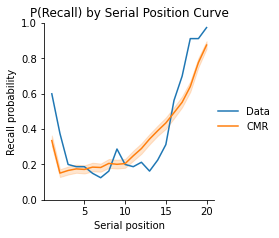

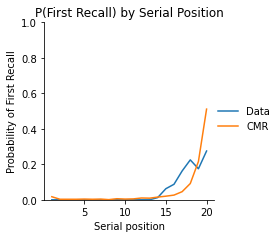

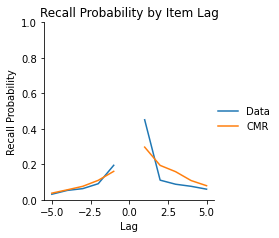

In [ ]:
parameters = {
    'item_count':murd_length0,
    'encoding_drift_rate': .8,
    'start_drift_rate': .7,
    'recall_drift_rate': .8,
    'shared_support': 0.01,
    'item_support': 1.0,
    'learning_rate': .3,
    'primacy_scale': 1,
    'primacy_decay': 1,
    'stop_probability_scale': 0.01,
    'stop_probability_growth': 0.3,
    'choice_sensitivity': 2
}

visualize_fit(CMR, 
              {**parameters, **{free_parameters[i]:result.x[i] for i in range(len(result.x))}}, 
              murd_events0, 'subject == 1', experiment_count=1000, savefig=True)

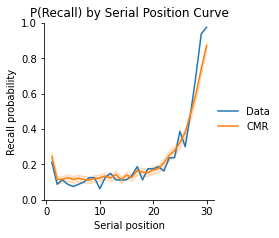

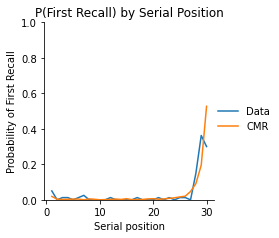

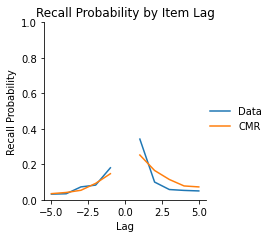

In [ ]:
parameters = {
    'item_count':murd_length1,
    'encoding_drift_rate': .8,
    'start_drift_rate': .7,
    'recall_drift_rate': .8,
    'shared_support': 0.01,
    'item_support': 1.0,
    'learning_rate': .3,
    'primacy_scale': 1,
    'primacy_decay': 1,
    'stop_probability_scale': 0.01,
    'stop_probability_growth': 0.3,
    'choice_sensitivity': 2
}

visualize_fit(CMR, 
              {**parameters, **{free_parameters[i]:result.x[i] for i in range(len(result.x))}}, 
              murd_events1, 'subject == 1', experiment_count=1000, savefig=True)

### Entire Dataset

For the entire 20-item Murd72 dataset, the results were:
```
     fun: 21224.80851136393
 message: 'Optimization terminated successfully.'
    nfev: 8121
     nit: 48
 success: True
       x: array([ 0.5993499 ,  0.05344888,  0.7478653 ,  0.21523541,  0.20109629,
        0.11414764,  5.67429377, 17.34679377,  0.0489872 ,  0.21252846,
        4.20191388])
```

In [ ]:
from scipy.optimize import differential_evolution
import numpy as np

free_parameters = [
    'encoding_drift_rate',
    'start_drift_rate',
    'recall_drift_rate',
    'shared_support',
    'item_support',
    'learning_rate',
    'primacy_scale',
    'primacy_decay',
    'stop_probability_scale',
    'stop_probability_growth',
    'choice_sensitivity']

lb = np.finfo(float).eps
ub = 1-np.finfo(float).eps

bounds = [
    (lb, ub),
    (lb, ub),
    (lb, ub),
    (lb, ub),
    (lb, ub),
    (lb, ub),
    (lb, 100),
    (lb, 100),
    (lb, ub),
    (lb, 10),
    (lb, 10)
]

# cost function to be minimized
# ours scales inversely with the probability that the data could have been 
# generated using the specified parameters and our model
cost_function = cmr_objective_function(List([murd_trials0, murd_trials1]), {'item_counts': List([murd_length0, murd_length1])}, free_parameters)

result = differential_evolution(cost_function, bounds, disp=True)
print(result)

differential_evolution step 1: f(x)= 107023
differential_evolution step 2: f(x)= 58382.9
differential_evolution step 3: f(x)= 58382.9
differential_evolution step 4: f(x)= 58382.9
differential_evolution step 5: f(x)= 58382.9
differential_evolution step 6: f(x)= 58382.9
differential_evolution step 7: f(x)= 56085.2
differential_evolution step 8: f(x)= 56085.2
differential_evolution step 9: f(x)= 56085.2
differential_evolution step 10: f(x)= 56085.2
differential_evolution step 11: f(x)= 56085.2
differential_evolution step 12: f(x)= 56085.2
differential_evolution step 13: f(x)= 55634.7
differential_evolution step 14: f(x)= 55634.7
differential_evolution step 15: f(x)= 55634.7
differential_evolution step 16: f(x)= 55634.7
differential_evolution step 17: f(x)= 55634.7
differential_evolution step 18: f(x)= 55634.7
differential_evolution step 19: f(x)= 55634.7
differential_evolution step 20: f(x)= 55634.7
differential_evolution step 21: f(x)= 55634.7
differential_evolution step 22: f(x)= 55634.

C:\Users\gunnj\miniconda3\lib\site-packages\scipy\optimize\_numdiff.py:557: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0


     fun: 50697.92288549975
 message: 'Optimization terminated successfully.'
    nfev: 9441
     nit: 55
 success: True
       x: array([5.90422803e-01, 5.33541229e-02, 7.94015489e-01, 2.56195624e-01,
       8.60968980e-01, 1.45279643e-01, 6.54923908e+00, 4.20183468e+01,
       1.32345570e-02, 3.03551385e-01, 4.37106316e+00])


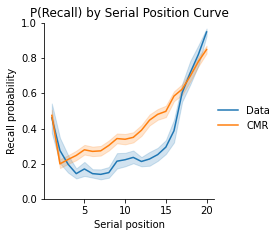

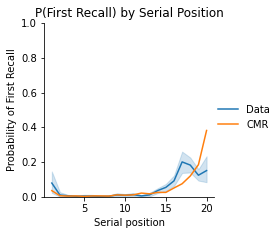

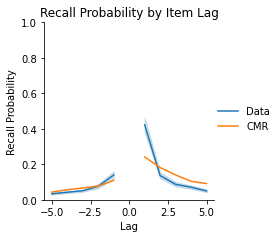

In [ ]:
parameters = {
    'item_count': murd_length0,
    'encoding_drift_rate': .8,
    'start_drift_rate': .7,
    'recall_drift_rate': .8,
    'shared_support': 0.01,
    'item_support': 1.0,
    'learning_rate': .3,
    'primacy_scale': 1,
    'primacy_decay': 1,
    'stop_probability_scale': 0.01,
    'stop_probability_growth': 0.3,
    'choice_sensitivity': 2
}

visualize_fit(CMR, {**parameters, **{free_parameters[i]:result.x[i] for i in range(len(result.x))}}, 
        murd_events0, 'subject > -1', experiment_count=1000, savefig=True)

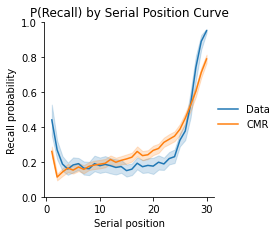

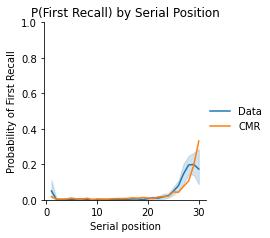

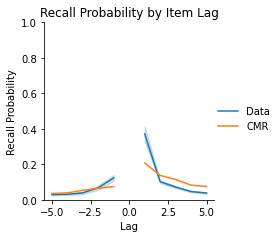

In [ ]:
parameters = {
    'item_count': murd_length1,
    'encoding_drift_rate': .8,
    'start_drift_rate': .7,
    'recall_drift_rate': .8,
    'shared_support': 0.01,
    'item_support': 1.0,
    'learning_rate': .3,
    'primacy_scale': 1,
    'primacy_decay': 1,
    'stop_probability_scale': 0.01,
    'stop_probability_growth': 0.3,
    'choice_sensitivity': 2
}

visualize_fit(CMR, {**parameters, **{free_parameters[i]:result.x[i] for i in range(len(result.x))}}, 
        murd_events1, 'subject > -1', experiment_count=1000, savefig=True)